# Project Part 1 - Collective Analysis
Analyzing Masking Policies and Progression of Covid Cases in Philadelphia, PA

In [1]:
# Importing all required libraries
# All libraries can be installed with pip
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.stats import ttest_ind
import ruptures as rpt

## Step 0: Data Aquistition

### Ingesting Data
We will be using 3 datasets for this analysis:

1) us_confirmed: RAW_us_confirmed_cases.csv from Kaggle

2) mask_mandates: CDC data of masking mandates

3) mask_compliance: Data from the New York Times mask compliance survey

4) vaccines_df: Data from Open Data Philly about vaccination counts over time

In [2]:
us_confirmed = pd.read_csv('RAW_us_confirmed_cases.csv')
mask_mandates = pd.read_csv('U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv')
mask_compliance = pd.read_csv('mask-use-by-county.csv')
vaccine_df = pd.read_csv('covid_vaccines_by_date.csv')

In [3]:
us_confirmed.head()

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22,10/31/22,11/1/22
0,Alabama,Autauga,84001001,US,USA,840,1001.0,US,32.539527,-86.644082,...,18480,18480,18480,18480,18511,18511,18511,18511,18511,18511
1,Alabama,Baldwin,84001003,US,USA,840,1003.0,US,30.727750,-87.722071,...,65895,65895,65895,65895,65973,65973,65973,65973,65973,65973
2,Alabama,Barbour,84001005,US,USA,840,1005.0,US,31.868263,-85.387129,...,6926,6926,6926,6926,6930,6930,6930,6930,6930,6930
3,Alabama,Bibb,84001007,US,USA,840,1007.0,US,32.996421,-87.125115,...,7560,7560,7560,7560,7575,7575,7575,7575,7575,7575
4,Alabama,Blount,84001009,US,USA,840,1009.0,US,33.982109,-86.567906,...,17286,17286,17286,17286,17320,17320,17320,17320,17320,17320


In [4]:
mask_mandates.head()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
0,AL,Autauga County,1,1,4/10/2020,2,NaN,NaN,NaN,NaN
1,AL,Autauga County,1,1,4/11/2020,2,NaN,NaN,NaN,NaN
2,AL,Autauga County,1,1,4/12/2020,2,NaN,NaN,NaN,NaN
3,AL,Autauga County,1,1,4/13/2020,2,NaN,NaN,NaN,NaN
4,AL,Autauga County,1,1,4/14/2020,2,NaN,NaN,NaN,NaN


In [5]:
mask_compliance.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459


In [6]:
vaccine_df.head()

,week_of_vaccination,partially_vaccinated,fully_vaccinated,boosted,annotation,etl_timestamp
0,11/14/2021 12:00:00 AM,8879,7151,29020.0,NaN,2022-10-31 11:00:01
1,12/12/2021 12:00:00 AM,13294,9677,36616.0,NaN,2022-10-31 11:00:01
2,7/10/2022 12:00:00 AM,2113,1416,1983.0,NaN,2022-10-31 11:00:01
3,10/31/2021 12:00:00 AM,7294,8333,27155.0,NaN,2022-10-31 11:00:01
4,7/25/2021 12:00:00 AM,1411,7688,69.0,NaN,2022-10-31 11:00:01


## Step 1: Analyze
### Cleaning Data
#### Include Only Data for Philadelphia, PA

In [7]:
# State Name is Pennsylvania and County Name is Philadelphia for this dataset
us_confirmed_pa = us_confirmed[(us_confirmed['Province_State'] == 'Pennsylvania') & (us_confirmed['Admin2'] == 'Philadelphia')]
us_confirmed_pa

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22,10/31/22,11/1/22
2382,Pennsylvania,Philadelphia,84042101,US,USA,840,42101.0,US,40.003385,-75.137927,...,366590,368038,368038,368757,368757,368757,368757,368757,369330,369330


In [8]:
pd.options.mode.chained_assignment = None #Get rid of false chained warning

# State Name is PA and County Name is Philadelphia County for this dataset
mask_mandates_pa = mask_mandates[(mask_mandates['State_Tribe_Territory'] == 'PA') & (mask_mandates['County_Name'] == "Philadelphia County")]
mask_mandates_pa['date'] = pd.to_datetime(mask_mandates_pa['date'])
mask_mandates_pa.head()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
610260,PA,Philadelphia County,42,101,2020-04-10,2,NaN,NaN,NaN,NaN
610261,PA,Philadelphia County,42,101,2020-04-11,2,NaN,NaN,NaN,NaN
610262,PA,Philadelphia County,42,101,2020-04-12,2,NaN,NaN,NaN,NaN
610263,PA,Philadelphia County,42,101,2020-04-13,2,NaN,NaN,NaN,NaN
610264,PA,Philadelphia County,42,101,2020-04-14,2,NaN,NaN,NaN,NaN


In [9]:
# COUNTYFP is 42101 as found in the FIPS columns in the above datasets
mask_compliance_pa = mask_compliance[mask_compliance['COUNTYFP'] == 42101][["NEVER", 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
mask_compliance_pa = pd.melt(mask_compliance_pa, var_name = "Mask_Usage", value_name = "Percentage")
mask_compliance_pa

,Mask_Usage,Percentage
0,NEVER,0.023
1,RARELY,0.012
2,SOMETIMES,0.051
3,FREQUENTLY,0.120
4,ALWAYS,0.794


#### Pivot us_confirmed_pa
We are going to pivot this table so we can get a dataframe with the dates and the number of confirmed cases assosciated with each date as a row. We will also convert the dates to a pandas datetime object to make further analysis easier

In [10]:
us_confirmed_pa_sub = us_confirmed_pa.loc[:,'1/22/20':] # only keep date values
us_confirmed_pa_fin = pd.melt(us_confirmed_pa_sub, var_name = 'date', value_name = 'num_cases') # turn columns into rows
us_confirmed_pa_fin['date'] = pd.to_datetime(us_confirmed_pa_fin['date'])
us_confirmed_pa_fin.head()

,date,num_cases
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,0
3,2020-01-25,0
4,2020-01-26,0


In [11]:
# Converting string to datetime
vaccine_df['week_of_vaccination'] = pd.to_datetime(vaccine_df['week_of_vaccination'])

## Step 2: Visualize
### Finding Gradients

In [12]:
us_confirmed_pa_fin["cases_rate"] = pd.Series(np.gradient(us_confirmed_pa_fin["num_cases"]), us_confirmed_pa_fin["date"], name='cases_rate').values
us_confirmed_pa_fin.head()

,date,num_cases,cases_rate
0,2020-01-22,0,0.0
1,2020-01-23,0,0.0
2,2020-01-24,0,0.0
3,2020-01-25,0,0.0
4,2020-01-26,0,0.0


### Merge Dataframes to Get All Information
Now we will be merging the mask mandates and covid cases dataframes so we can know the case count and whether a face mask was required in public for each day

In [13]:
covid_df = pd.merge(us_confirmed_pa_fin, mask_mandates_pa, how = 'left', left_on = 'date', right_on = 'date')[['date', 'num_cases', 'cases_rate', 'Face_Masks_Required_in_Public']]
covid_df['Face_Masks_Required_in_Public'] = covid_df['Face_Masks_Required_in_Public'].fillna('No')
covid_df.head()

,date,num_cases,cases_rate,Face_Masks_Required_in_Public
0,2020-01-22,0,0.0,No
1,2020-01-23,0,0.0,No
2,2020-01-24,0,0.0,No
3,2020-01-25,0,0.0,No
4,2020-01-26,0,0.0,No


### Calculate Change Points 
This will show where the difference in the derivative function was significant

In [14]:
# Change points for rate of cases
algo_rate = rpt.Pelt(model="rbf").fit(np.array(covid_df['cases_rate']))
change_rate = algo_rate.predict(pen=10)
change_rate = covid_df.iloc[change_rate[:-1]].date.to_list()

# Change points for number of cases
algo_num = rpt.Pelt(model="rbf").fit(np.array(covid_df['num_cases']))
change_num = algo_num.predict(pen=10)
change_num = covid_df.iloc[change_num[:-1]].date.to_list()

### Graphing Gradient
To graph the values and show where there was masking mandates I created a function to create a bunch of traces of the data. It creates and appends a new trace whenever the mask mandate switches from yes to no. This allows us to changed the color of the line based on the mask mandate. Finally we put all the traces together and return the graph

In [15]:
def plot_graph_by_mandate(y_var, covid_df, graph_title, change):
    col = {'No': 'red', 'Yes': 'blue'} #Dictionary to set colors for mask mandate values
    legend_val = {'No': 'No Face Covering Required', 'Yes': 'Face Covering Required'}
    fig = go.Figure(layout=go.Layout(
        title=go.layout.Title(text=graph_title)
    ))
    
    curr_cat = 'start'
    x = []
    y = []
    plotted = []
    for index, row in covid_df.iterrows():
        if (row['Face_Masks_Required_in_Public'] == curr_cat or index == 0) and index != covid_df.shape[0] - 1:
            curr_cat = row['Face_Masks_Required_in_Public']
            # Append values to x and y if we are in the same category
            x.append(row['date'])
            y.append(row[y_var])
        else:
            # Create new trace if we are switching categories
            trace = go.Scatter(x=x, y=y, 
                                                  legendgroup=legend_val[curr_cat],  # group identical categories
                                                  showlegend=curr_cat not in plotted,  # hide legend if already plotted
                                                  name=legend_val[curr_cat],
                                                  marker={'color': col[curr_cat]})
            x = []
            y = []
            plotted.append(curr_cat)
            fig.add_trace(trace)
            curr_cat = row['Face_Masks_Required_in_Public']
    ymax = max(covid_df[y_var])
    for i in range(len(change)):
        curr = change[i]
        fig.add_trace(go.Scatter(x=[curr]*100, 
                         y=[0,ymax], 
                         mode='lines', 
                         line=dict(color='black', width=2, dash='dash'),
                         name='Change Points',
                                showlegend = i == 0))  
    fig.update_yaxes(title_text=y_var)
    fig.update_layout(
    autosize=True,
    width=1000,
    height=500
    )
    return fig

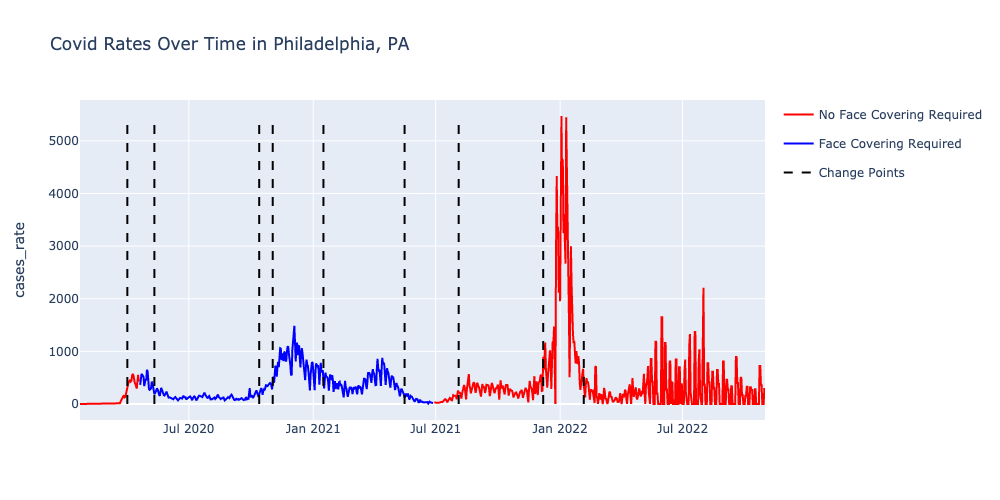

In [16]:
fig = plot_graph_by_mandate('cases_rate', covid_df, 'Covid Rates Over Time in Philadelphia, PA', change_rate)
fig.write_image('covid_rates.png')
fig.show(renderer = "png")

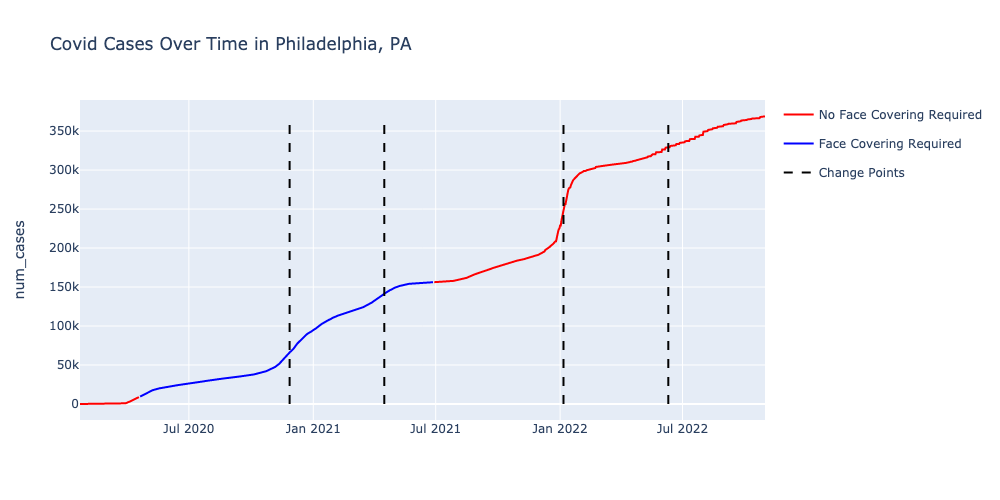

In [17]:
fig = plot_graph_by_mandate('num_cases', covid_df, 'Covid Cases Over Time in Philadelphia, PA', change_num)
fig.write_image('covid_cases.png')
fig.show(renderer = "png")

### Graphing Mask Compliance

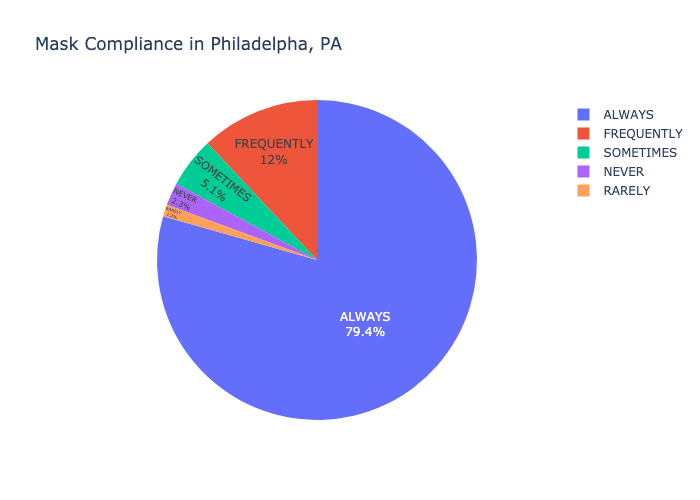

In [18]:
fig = px.pie(mask_compliance_pa, values = "Percentage", names = "Mask_Usage", title = "Mask Compliance in Philadelpha, PA")
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.write_image('mask_compliance.png')
fig.show(renderer = "png")

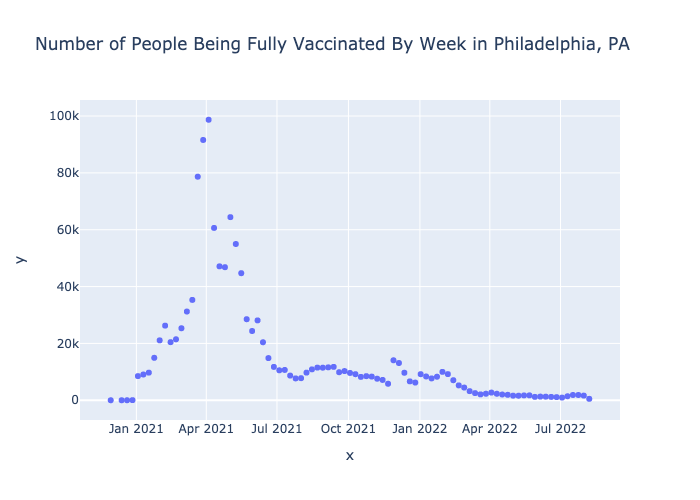

In [19]:
fig = px.scatter(x = vaccine_df['week_of_vaccination'], y = vaccine_df['fully_vaccinated'], title = "Number of People Being Fully Vaccinated By Week in Philadelphia, PA")
fig.write_image('vaccinations.png')
fig.show(renderer = "png")

# DATA 512 Project Part 2
### Exploring How the Pandemic Affected the Housing Market in Philadelphia, PA

## Ingesting Housing Market Data
Data from Zillow, described below:

1) Rentals: Data about Zillow Observed Rent Index (ZORI),  a smoothed measure of the typical observed market rate rent across a given region.The index is dollar-denominated by computing the mean of listed rents that fall into the 40th to 60th percentile range for all homes and apartments in a given region. This data is separated by counties all across America and has data monthly from March 2015 to September 2022. There is also a dataset available that adjusts for seasonality. This will help me answer the question by giving access to how the mean rent has changed before, during and after the pandemic which will allow us to compare that change to the rate of change in covid cases.

2) For Sale Inventory: Data about current listings on Zillow. The data includes the count of unique listings that were active at any time in a given month. This includes data from March 2018 to September 2022 with the number of listings reported for each month. This will help me answer the question by giving access to how the number of listings has changed before, during and after the pandemic which will allow us to compare that change to the rate of change in covid cases.

3) Sale-to-List Ratio (mean/median): This includes data from March 2018 to September 2022 with the ratio of sale vs. final price monthly. This will help me answer the question by giving access to how the sale to list ratio has changed before, during and after the pandemic which will allow us to compare that change to the rate of change in covid cases. We will be able to examine if houses sold over or under the listing rate over the course of a couple years.


In [20]:
rentals = pd.read_csv("County_zori_sm_sa_month.csv")
for_sale = pd.read_csv("Metro_invt_fs_uc_sfrcondo_sm_month.csv")
sale_list_ratio = pd.read_csv('Metro_median_sale_to_list_uc_sfrcondo_sm_month.csv')

## Filtering data to only include data from Philadelphia County
The zillow data includes data from many different major cities in America. Below we create a function to filter only data from Philadelphia county as well as pivot the data so the data is formatted by date and value

### Create Function to easily Clean Data From Zillow

In [21]:
def clean_data(df, region, start_date, val):
    df_new = df[df.RegionName == region]
    df_new = df_new.loc[:, start_date:]
    df_new = pd.melt(df_new, var_name = 'date', value_name = val)
    df_new['date'] = pd.to_datetime(df_new['date'])
    return df_new

### Run function on all Zillow Data Sets

In [22]:
rentals_pa = clean_data(rentals, 'Philadelphia County', '2015-03-31', 'ZORI')
for_sale_pa = clean_data(for_sale, 'Philadelphia, PA', '2018-03-31', 'num_listings')
sale_list_ratio_pa = clean_data(sale_list_ratio, 'Philadelphia, PA', '2018-03-31', 'sale_to_list_ratio')

## Graphing Housing Data Against Covid Rates

## Creating Function to easily graph data
We graph using seaborn and overlay each of the Zillow datasets with the covid rates we calculated in Part 1

In [23]:
def graph_housing_covid(df, col_name, title):
    fig, ax = plt.subplots(figsize = (25,15))
    plt.rcParams.update({'font.size': 22})
    plt.rc('axes', titlesize = 18)
    #sns.set(rc={'figure.figsize':(25,25)})
    
    df = df[df.date >= '2018-01-01']
    sns.lineplot(x = 'date', y = col_name, data = df, label = col_name).set(title = title)
    ax.get_legend().remove()
    ax.grid(False)
    ax2 = plt.twinx()
    sns.lineplot(x = 'date', y = 'cases_rate', data = covid_df, color = 'orange', label = 'Covid Rate')
    ax2.get_legend().remove()

    fig.legend(loc='upper right')
    plt.show()

### Rental Data

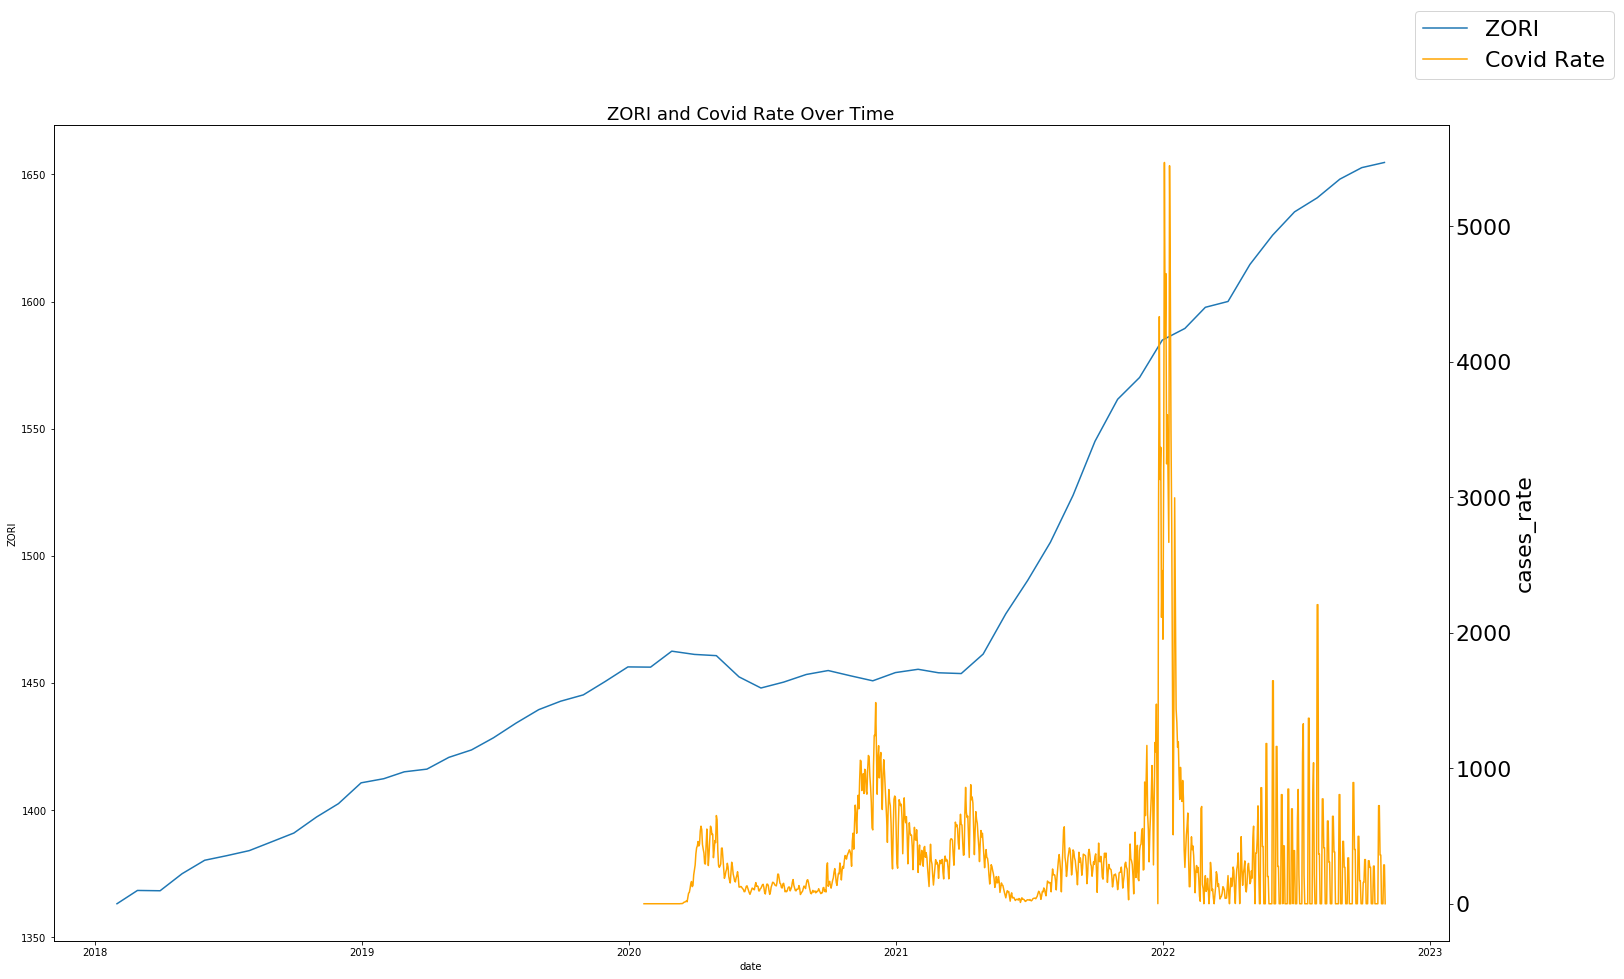

In [24]:
graph_housing_covid(rentals_pa, 'ZORI', 'ZORI and Covid Rate Over Time')

### For-Sale Inventory

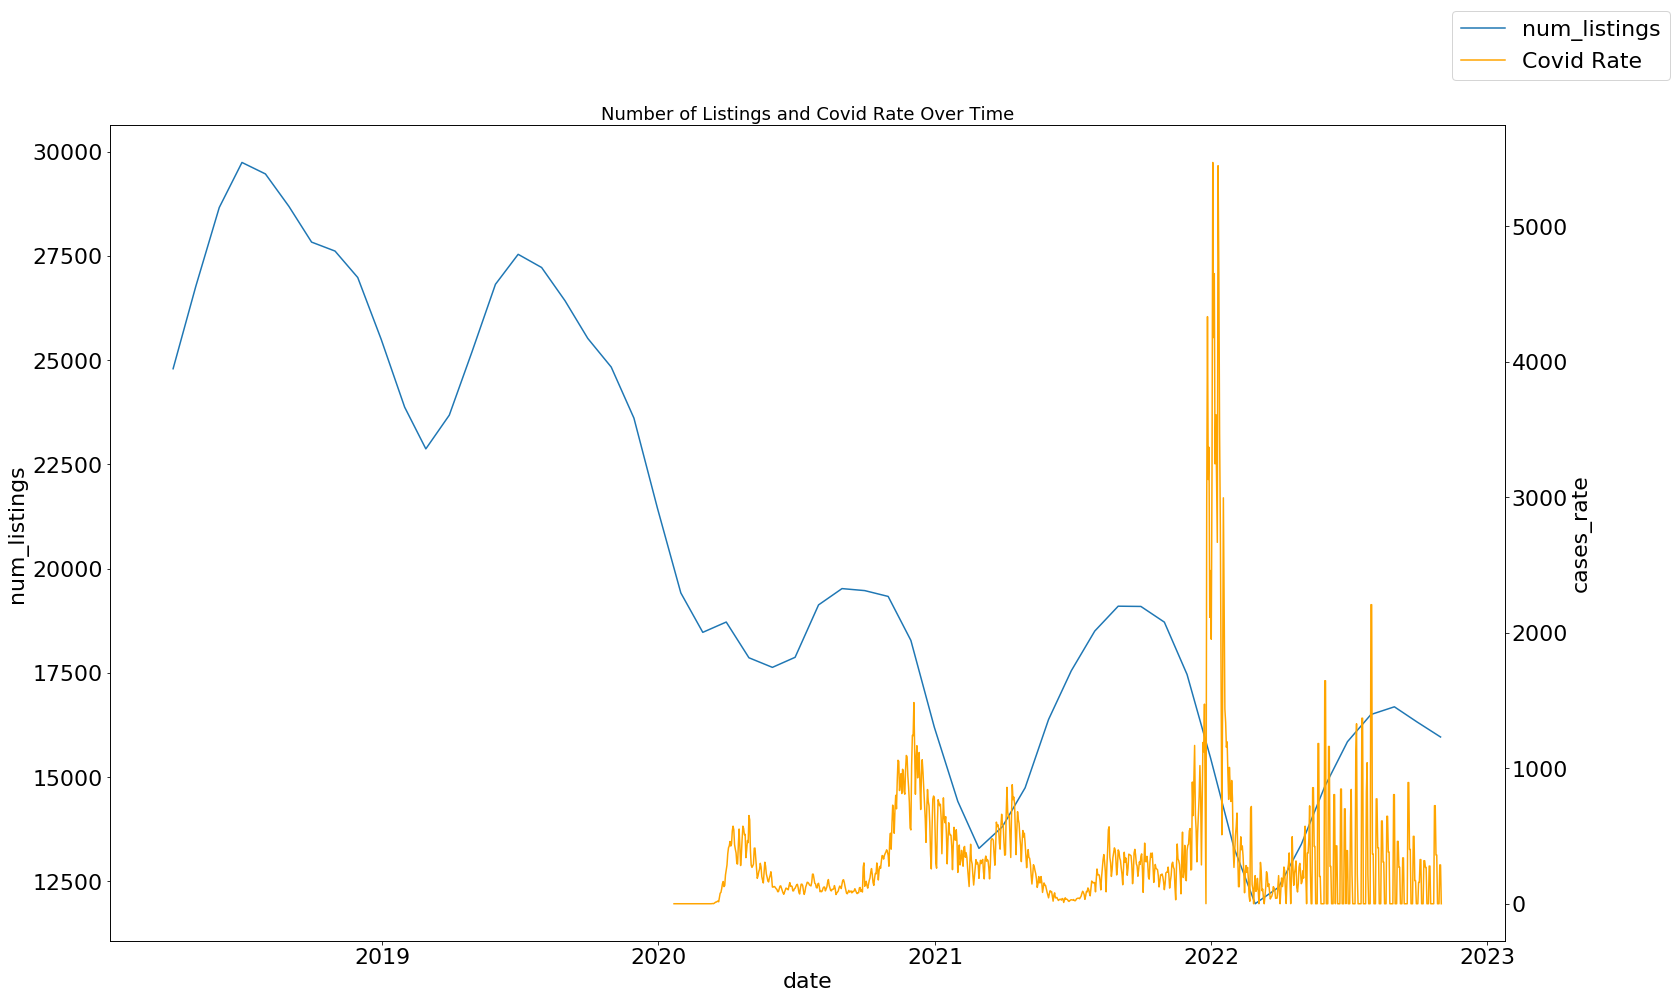

In [25]:
graph_housing_covid(for_sale_pa, 'num_listings', 'Number of Listings and Covid Rate Over Time')

### Sale to List Ratio

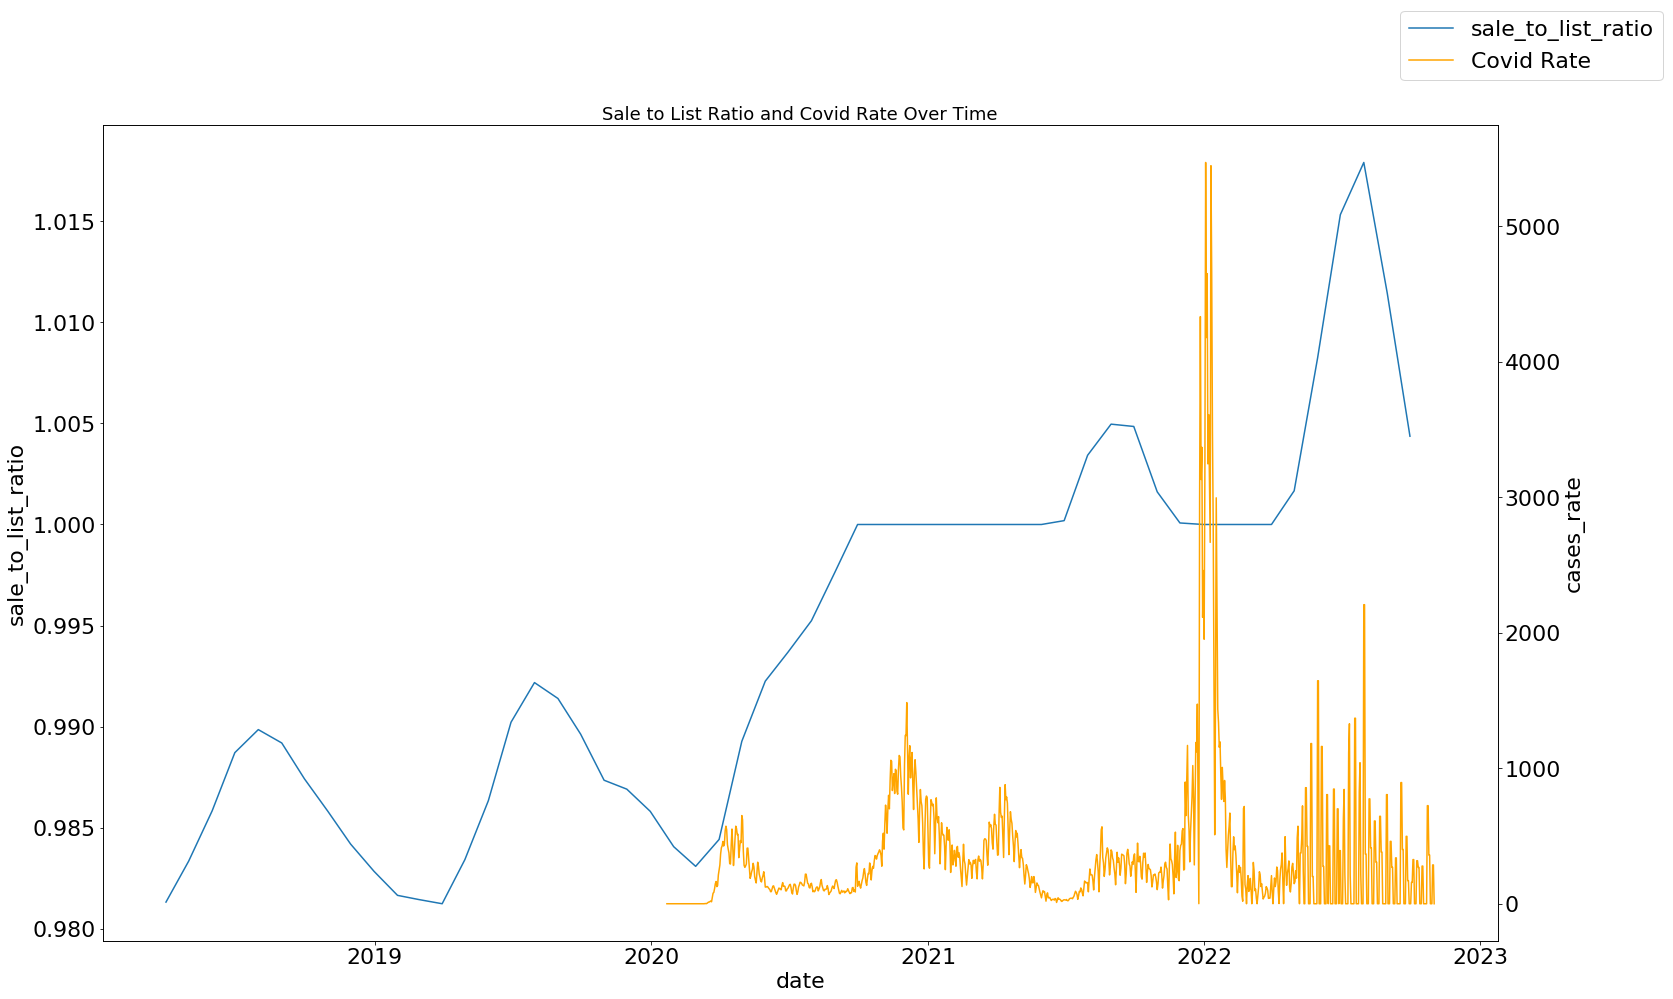

In [26]:
graph_housing_covid(sale_list_ratio_pa, 'sale_to_list_ratio', 'Sale to List Ratio and Covid Rate Over Time')

## Statistical Tests

### Create function to perform t-tests
We divide the data sets into pre-covid (before January 1st, 2020) and during covid. We create a function to use a t-test to compare if there was a statistically significant difference between the mean of the values before and during the pandemic.

In [27]:
def t_test_covid(df, var):
    df_before = df[df.date < '2020-01-31']
    df_after = df[df.date >= '2020-01-31']
    
    return ttest_ind(df_before[var], df_after[var])

### Run function of For Sale Data

In [28]:
t_test_covid(for_sale_pa, 'num_listings')

Ttest_indResult(statistic=15.408463928728997, pvalue=2.0373464898376658e-21)

The p-value is less than our significant level of 0.05 so we reject the null hypothesis and conclude that we are 95% sure that the means of the number of listings before and during the pandemic are not equal.

In [29]:
t_test_covid(sale_list_ratio_pa, 'sale_to_list_ratio')

Ttest_indResult(statistic=-7.84525261914504, pvalue=1.977979945165158e-10)

The p-value is less than our significant level of 0.05 so we reject the null hypothesis and conclude that we are 95% sure that the means of the sale to list ratio before and during the pandemic are not equal.

### Supplemental 'Thick' Data
Some Quotes from news articles about housing in Philadelphia during the Pandemic. These are elaborated on in the final project write up

“Typically, in our previous research looking at property tax increases, the evidence shows that the landlords pass it on to the tenants” - Michael Shields, director of research for the Economy League of Greater Philadelphia

“There’s going to be a bunch of landlords selling their properties because we can’t pay for this anymore,” (In response to tenants being unable to pay rent) - Ebony Harris, Philadelphia Landlord

“The pandemic was kind of a pause on the economy and now that things are reopening, inflation is picking up, rents are going up and people are realizing they don’t have as much disposable income as they might have thought they had.” - Daryl Fairweather, Redfin’s chief economist